In [109]:
import psycopg2 as ps
from wordcloud import WordCloud
import  matplotlib.pyplot as plt 
import seaborn as sns
import re
import sys
sys.path.append('./TweetData')
from TweetData import keys, Preprocessing
import pandas as pd
import plotly.graph_objects as go
import json
from collections import Counter

In [55]:
# Cleaning the tweets
stop_words = json.load(open('./files/stop_words.json', encoding='utf8'))
def preprocess(tweet):
    # remove next lines
    tweet = re.sub('\n', ' ', tweet)
    # remove links
    tweet = re.sub('http\S+\s*', '', tweet)
    # remove between parentesis
    tweet = re.sub('\[.*\]','', tweet)
    # remove mentions
    tweet = re.sub("@\w+", "", tweet)
    # remove hashtags
    tweet = re.sub("#\w+", "", tweet)
    # alphanumeric and hashtags
    tweet = re.sub("[^a-zA-Z0-9ñáéíóúÁÉÍÓÚüÜ]", " ", tweet)
    # remove multiple spaces
    tweet = re.sub("\s+", " ", tweet)
    tweet = re.sub('^\s+', '', tweet)
    # lower first character
    try: tweet = tweet[0].lower() + tweet[1:]
    except: pass
    # remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') 
                if not word.lower() in stop_words])
    #replace tildes
    tweet = re.sub('á', 'a', tweet)
    tweet = re.sub('é', 'e', tweet)
    tweet = re.sub('í', 'i', tweet)
    tweet = re.sub('ó', 'o', tweet)
    tweet = re.sub('ú', 'u', tweet)
    tweet = re.sub('ü', 'u', tweet)

    return tweet

# WordClouds

In [58]:
## Clean text WordCloud
conn = ps.connect(
    database='traffictwt', user='postgres', password='root')
cursor = conn.cursor()
q = '''SELECT TWEET_TEXT FROM TWEETS '''
cursor.execute(q)
results = cursor.fetchall()
cursor.close()
conn.close()

### Before/After cleaning

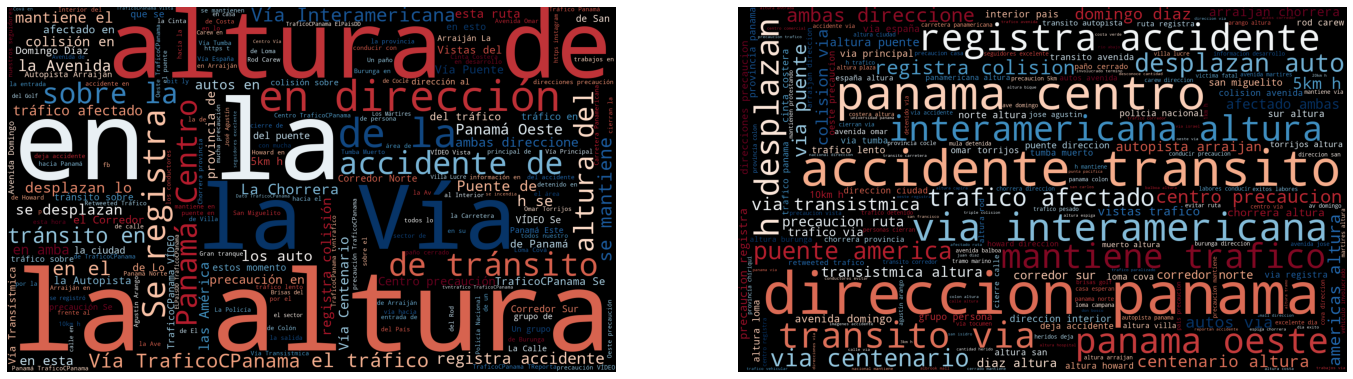

In [61]:
tweets = ' '.join(t[0] for t in results)
wc_orig = WordCloud(background_color='black', colormap='RdBu',
    width=1500, height=900).generate(tweets)
tweets = ' '.join([Preprocessing.preprocess(t[0]) for t in results])
wc_clean = WordCloud(background_color='black', colormap='RdBu',
    width=1500, height=900).generate(tweets)

plt.figure(figsize=(24,8))
plt.subplot(1, 2, 1)
plt.imshow(wc_orig)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wc_clean)
plt.axis('off')
plt.show()

### Words starting with mayus (Places)

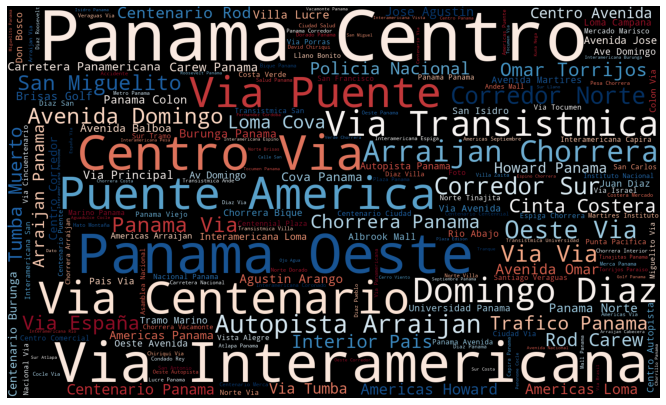

In [64]:
tweets = ' '.join(preprocess(t[0]) for t in results)
tweets = ' '.join(re.findall('([A-Z]\S+)', tweets))

wc = WordCloud(background_color='black', colormap='RdBu',
    width=1500, height=900).generate(tweets)

plt.figure(figsize=(12,7.2))
plt.imshow(wc)
plt.axis('off')
plt.show()

## Count Vectors

In [65]:
data = pd.DataFrame(results, columns=['text'])
data['clean'] = data.text
data['clean'] = data.apply(lambda row: preprocess(row.clean), axis=1)

In [150]:
counts = Counter(' '.join(data.clean).split())
freq = pd.DataFrame(counts.most_common(20), columns=['word', 'count'])

Text(0.5, 0, '')

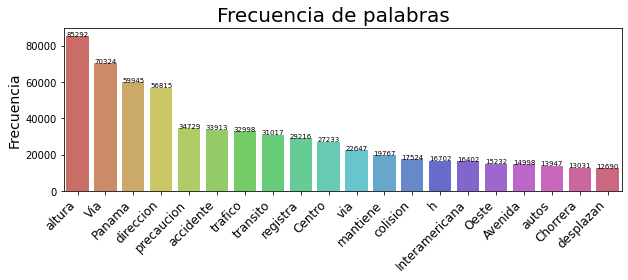

In [207]:
plt.figure(figsize=(10,3))
# plt.bar(x=feat_values, height=feat_imp.values)
# sns.barplot(x=feat_values, y=feat_imp.values, data=feat_imp, order=feat_imp.values)
plt.suptitle('Frecuencia de palabras', fontsize=20)
# plt.subplot(2, 1, 1)
bar = sns.barplot(x='word', y='count', data=freq, palette='hls')
# for index, row in freq.iterrows():
    # bar.text(index, row['count'], row['count'], color='black', ha="center", fontsize=7)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.ylabel('Frecuencia', fontsize=14)
# plt.tight_layout()
plt.xlabel(None)

## Cantidad de Tweets

In [158]:
## Clean text WordCloud
conn = ps.connect(
    database='traffictwt', user='postgres', password='root')
cursor = conn.cursor()
q = '''SELECT DATE_TRUNC('DAY', TWEET_CREATED) AS FECHA, COUNT(TWEET_CREATED) AS "COUNT"
	FROM TWEETS GROUP BY FECHA ORDER BY FECHA DESC; '''
cursor.execute(q)
results1 = cursor.fetchall()
cursor.close()
conn.close()

In [221]:
date_count = pd.DataFrame(results1, columns=['fecha', 'count'])
date_count['year'] = date_count.fecha.dt.year
date_count['month'] = date_count.fecha.dt.month

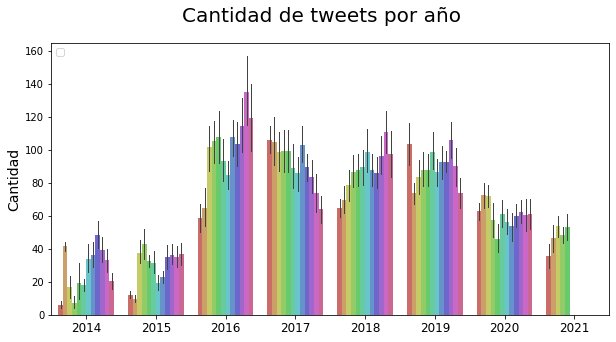

In [240]:
plt.figure(figsize=(10,5))
# plt.bar(x=feat_values, height=feat_imp.values)
# sns.barplot(x=feat_values, y=feat_imp.values, data=feat_imp, order=feat_imp.values)
plt.suptitle('Cantidad de tweets por año', fontsize=20)
# plt.subplot(2, 1, 1)
sns.barplot(x='year', y='count', hue='month', 
    data=date_count, palette='hls', errwidth=1)
# sns.lineplot(data=date_count[(date_count.year>2017) & (date_count.year<2021)], x='month', y='count', hue='year')
plt.xticks(fontsize=12)
plt.ylabel('Cantidad', fontsize=14)
# plt.tight_layout()
plt.xlabel(None)
plt.legend([],[])

# Notes

In [3]:
conn = ps.connect(database='traffictwt', user='postgres', password='root')

option = 'day'
query = '''
    SELECT
        COUNT(CASE WHEN I.ISACCIDENT THEN 1 END) AS ACCIDENTS,
        COUNT(CASE WHEN I.ISOBSTACLE THEN 1 END) AS OBSTACLES,
        COUNT(CASE WHEN I.ISDANGER THEN 1 END) AS DANGERS
    FROM TWTINCIDENT AS I LEFT JOIN TWTTWEET AS T
    ON I.INC_TWEET_ID=T.TWEET_ID
    WHERE T.TWEET_CREATED>(
        SELECT DATE_TRUNC('DAY', MAX(TWEET_CREATED) - INTERVAL '%i' %s) 
        FROM TWTTWEET
    );
    ''' % ((7 if option=='day' else 1), option)

cursor = conn.cursor()
try:
    cursor.execute(query)
    results = cursor.fetchall()
    colnames = [desc[0] for desc in cursor.description]
except Exception as e: print(e)
cursor.close()
results

[(83, 188, 3)]

In [16]:
db.connect(password=keys.db_pass)
q = '''
SELECT
    COUNT(CASE WHEN I.ISACCIDENT THEN 1 END) AS ACCIDENTS,
    COUNT(CASE WHEN I.ISOBSTACLE THEN 1 END) AS OBSTACLES,
    COUNT(CASE WHEN I.ISDANGER THEN 1 END) AS DANGERS
FROM TWTINCIDENT AS I LEFT JOIN TWTTWEET AS T
ON I.INC_TWEET_ID=T.TWEET_ID
WHERE T.TWEET_CREATED>(
    SELECT DATE_TRUNC('DAY', MAX(TWEET_CREATED) - INTERVAL '%i' %s) 
    FROM TWTTWEET
); ''' % ((7 if option=='week' else 1), option)
colnames, results = db.query(q)
db.close_connection()
df = pd.DataFrame(results, columns=colnames)
df

['accidents', 'obstacles', 'dangers'] [(16, 17, 0)]


,accidents,obstacles,dangers
0,16,17,0


In [15]:
data = pd.DataFrame([[1, 2, 3], [3, 4, 5], [6, 7, 8]], 
    columns=['one', 'two', 'three'])
data

,one,two,three
0,1,2,3
1,3,4,5
2,6,7,8


In [16]:
data2 = pd.DataFrame([[3, 4, 5], [7, 8, 9], [1, 3, 5]], 
    columns=['one', 'two', 'three'])
data2

,one,two,three
0,3,4,5
1,7,8,9
2,1,3,5


In [5]:
string = 'esto es una prueba'
[word for word in string.split(' ')]

['esto', 'es', 'una', 'prueba']

In [2]:
data3 = pd.DataFrame(columns=['one', 'two', 'three'])
len(data3)

0

In [17]:
data.merge(data2, how='outer')

,one,two,three
0,1,2,3
1,3,4,5
2,6,7,8
3,7,8,9
4,1,3,5


In [8]:
for index, i in data.iterrows():
    print(i.one)

1


In [41]:
max(data.iloc[0,:])

3

In [11]:
data.columns.values.tolist()

['one', 'two', 'three']